# Module 2 — 2.7(A): Hands-On — Housing Regression with expanded explanations

**Goal:** End-to-end regression on a realistic (synthetic) housing dataset with *intentional messiness*.

**Steps**
1) Generate & inspect
2) Clean & prepare 
3) Train/Test Split 
4) OLS baseline  
5) Polynomial (deg 2/3)  
6) Ridge/Lasso/ElasticNet  
7) Metrics (RMSE/MAE/R²/MAPE)  
8) GridSearchCV  
9) Reflection


## 0) Database Set-up

In [1]:
import numpy as np 
import pandas as pd

def make_housing_realistic(n=900, seed=1955, noise=20000):
    rng = np.random.default_rng(seed)
    sqft = np.clip(rng.normal(1800, 600, n), 450, 4200)
    beds = np.clip(np.round(sqft/800 + rng.normal(0,0.6,n)), 1, 6).astype(int)
    baths= np.clip(beds - 1 + rng.normal(0.2,0.5,n), 1, 4).round().astype(int)
    age  = np.clip(rng.gamma(2.0,12.0,n), 0, 120)
    lot  = np.clip((sqft/5000)+rng.lognormal(-3.2,0.4,n), 0.03, 1.5)
    dist = np.clip(rng.lognormal(2.3,0.5,n), 0.5, 45)
    base, c_sq,c_b,c_ba,c_a,c_l,c_d = 75000,130,12000,9000,-400,85000,-2800
    inter = 0.02*sqft/np.sqrt(dist)
    eps   = rng.normal(0, noise+0.02*sqft, n)
    price = (base + c_sq*sqft + c_b*beds + c_ba*baths + c_a*age + c_l*lot + c_d*dist + inter + eps)
    df = pd.DataFrame({'sqft':sqft.round(0),'bedrooms':beds,'bathrooms':baths,
                       'age_years':age.round(0),'lot_size':lot.round(3),
                       'dist_to_center_km':dist.round(2),'price':price.round(0)})
    # messiness: missing/invalids
    rng = np.random.default_rng(seed+1)
    df.loc[rng.random(n)<0.08,'sqft']=np.nan
    df.loc[rng.random(n)<0.05,'lot_size']=np.nan
    bad = df.sample(3, random_state=seed+2).index
    df.loc[bad,'sqft']=[0,-50,12000]
    df.loc[df.sample(2, random_state=seed+3).index,'dist_to_center_km']=[0,999]
    df.loc[rng.random(n)<0.02,'price']=np.nan
    return df


## 1) Generate & inspect

In [2]:
# --- 1) Generate & inspect ---
df = make_housing_realistic()
df.head()


,sqft,bedrooms,bathrooms,age_years,lot_size,dist_to_center_km,price
0,2148.0,4,3,13.0,0.494,3.66,450390.0
1,1908.0,2,1,23.0,NaN,3.65,375746.0
2,2368.0,2,2,77.0,0.502,12.37,394964.0
3,2916.0,4,4,6.0,0.649,12.66,561309.0
4,1208.0,1,1,8.0,0.270,4.96,280848.0


**Sanity-check:** column names, types, rough ranges, missing values, and impossible values (e.g., `sqft` ≤ 0).

In [3]:
df.info() 
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sqft               821 non-null    float64
 1   bedrooms           900 non-null    int64  
 2   bathrooms          900 non-null    int64  
 3   age_years          900 non-null    float64
 4   lot_size           848 non-null    float64
 5   dist_to_center_km  900 non-null    float64
 6   price              878 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 49.3 KB


,sqft,bedrooms,bathrooms,age_years,lot_size,dist_to_center_km,price
count,821.000000,900.000000,900.000000,900.000000,848.000000,900.000000,878.000000
mean,1834.535932,2.337778,1.750000,23.412222,0.410336,12.123856,350830.318907
std,695.998068,0.954653,0.900346,16.700198,0.120428,33.497648,105473.843947
min,-50.000000,1.000000,1.000000,1.000000,0.115000,0.000000,89611.000000
25%,1398.000000,2.000000,1.000000,11.000000,0.327000,6.895000,276939.500000
50%,1830.000000,2.000000,1.000000,20.000000,0.415500,9.670000,350419.000000
75%,2263.000000,3.000000,2.000000,32.000000,0.494000,13.645000,426597.000000
max,12000.000000,6.000000,4.000000,110.000000,0.732000,999.000000,735069.000000


#### Understanding the Housing Dataset

This dataset is a **realistic synthetic housing dataset** created for practicing
data cleaning, feature engineering, and regression modeling.

Each row represents a single house, and each column represents a feature the model
can use to predict its **sale price**.

##### Feature overview
- **sqft** — Interior living area. One of the strongest predictors of price.  
- **bedrooms** — Number of bedrooms. Roughly correlated with `sqft`.  
- **bathrooms** — Bathrooms usually increase price but at a diminishing rate.  
- **age_years** — Older homes typically sell for less, holding other factors constant.  
- **lot_size** — Land area (acres). Highly valuable, often nonlinear in effect.  
- **dist_to_center_km** — Distance to the city center. Homes farther away tend to be cheaper.  
- **price** — The target we want to predict.

##### Why the dataset contains “messiness”
To mimic real-world scenarios, the dataset includes:
- Missing values (e.g., unknown `sqft`, `lot_size`)
- Invalid values (e.g., zero or negative square footage)
- Extreme outliers (e.g., very large `dist_to_center_km`)
- Noise in pricing (larger homes have more price variance)

This messiness is intentional — it creates opportunities to:
- practice **data cleaning**,  
- explore **model sensitivity**,  
- and understand how messy data impacts predictions.

##### What to look for during inspection
- Are there missing or impossible values?  
- Do the numeric ranges make sense?  
- Are some features right-skewed (e.g., lot size, distance)?  
- Which features likely have strong relationships with price?

Before modeling, we must clean and prepare the data — that work starts in Step 2.


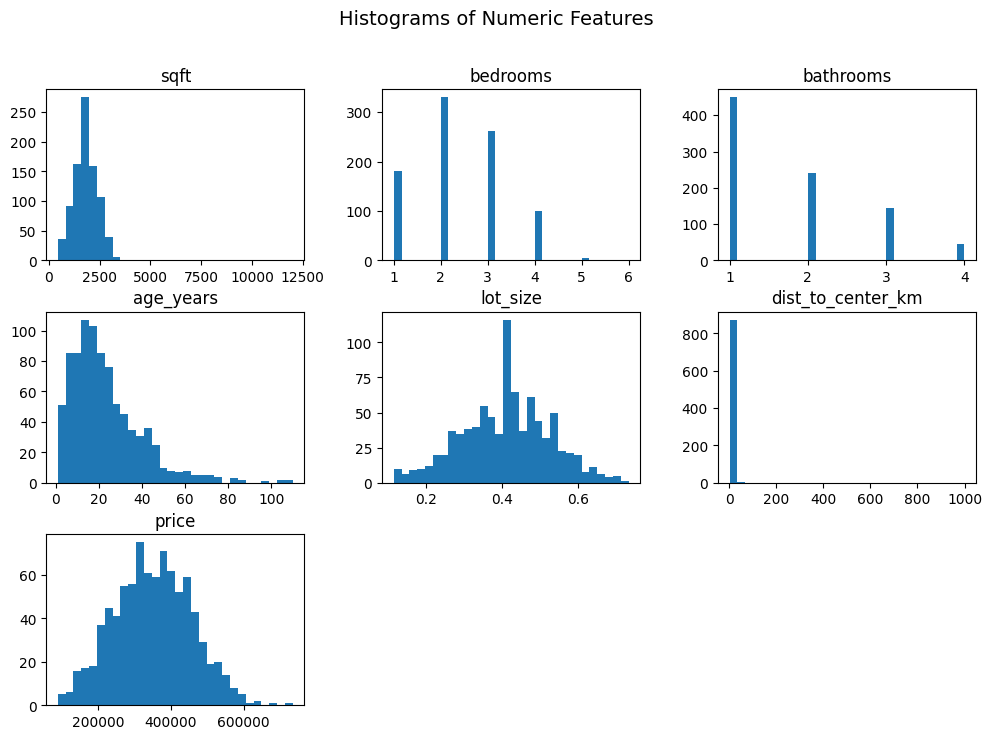

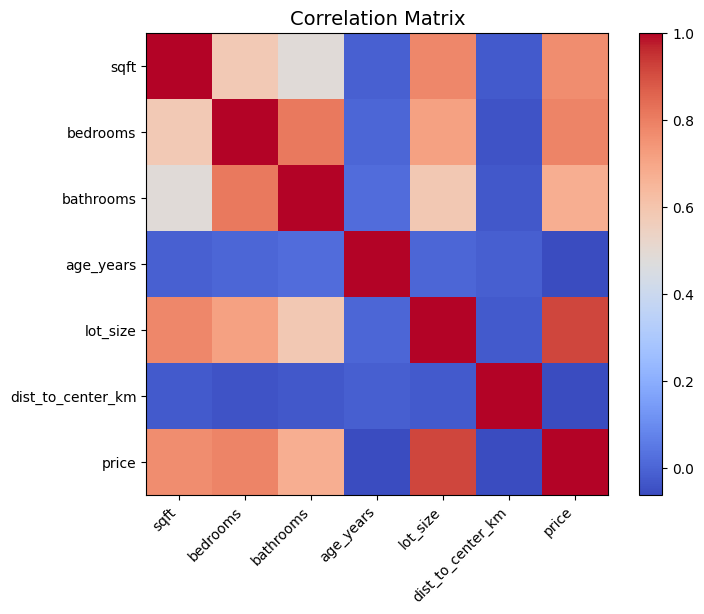

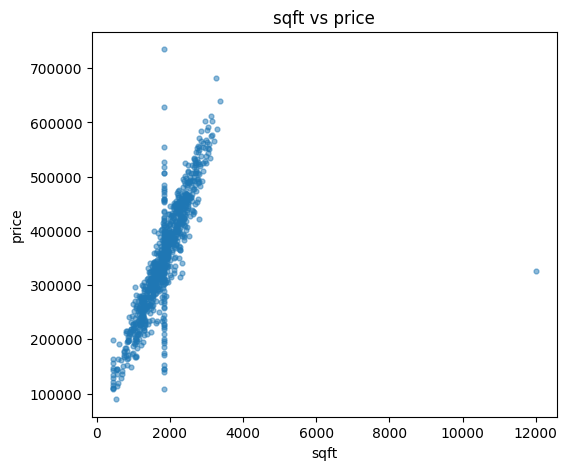

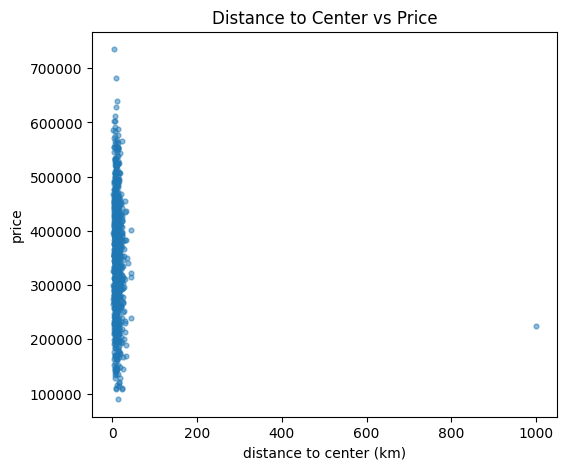

In [5]:
# --- Visual Exploratory Data Analysis (EDA) ---

import matplotlib.pyplot as plt
#import numpy as np

# Select numeric columns for summary visualization
num_cols = ["sqft", "bedrooms", "bathrooms", "age_years", "lot_size", "dist_to_center_km", "price"]

# ---------------------------------------------------------
# 1) Histograms for each numeric column
# ---------------------------------------------------------
df[num_cols].hist(bins=30, figsize=(12, 8), grid=False)
plt.suptitle("Histograms of Numeric Features", fontsize=14)
plt.show()

# ---------------------------------------------------------
# 2) Correlation matrix (heatmap-style using Matplotlib)
# ---------------------------------------------------------
corr = df[num_cols].corr()

plt.figure(figsize=(8,6))
plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Correlation Matrix", fontsize=14)
plt.show()

# ---------------------------------------------------------
# 3) Scatter plot: sqft vs price
# ---------------------------------------------------------
plt.figure(figsize=(6,5))
plt.scatter(df["sqft"], df["price"], s=12, alpha=0.5)
plt.xlabel("sqft")
plt.ylabel("price")
plt.title("sqft vs price")
plt.show()

# ---------------------------------------------------------
# 4) Scatter plot: dist_to_center_km vs price
# ---------------------------------------------------------
plt.figure(figsize=(6,5))
plt.scatter(df["dist_to_center_km"], df["price"], s=12, alpha=0.5)
plt.xlabel("distance to center (km)")
plt.ylabel("price")
plt.title("Distance to Center vs Price")
plt.show()


### Visual Exploration of the Housing Dataset

Before we clean or model the data, it helps to *see* the structure and
distributions of the features.

#### What we learn from the histograms
- Many real-world housing features are **right-skewed**  
  (e.g., `lot_size`, `dist_to_center_km`).
- Some features cluster tightly (e.g., bedrooms), while others vary widely (sqft, price).
- This helps us choose appropriate models and spot issues early.

#### What the correlation matrix shows
- **sqft**, **bedrooms**, and **bathrooms** are positively correlated with price.  
- **dist_to_center_km** is negatively correlated with price.  
- Some predictors are correlated with each other (e.g., sqft & bedrooms),  
  which is why regularization (Ridge/Lasso) will matter later.

#### Scatter plots: relationships with price
- **sqft vs price** ⇒ strong positive trend, but with curvature and increasing noise.  
- **distance vs price** ⇒ homes farther from the city are cheaper, but the relationship is noisy.  

These visual patterns help explain why:
- OLS performs well but not perfectly,  
- Polynomial regression improves results, and  
- Regularization stabilizes models with correlated predictors.

This EDA sets the stage for the cleaning (Step 2) and modeling steps that follow.


## 2) Clean & prepare

We will clean missing/invalid values next.

In [6]:
# --- 2) Clean & prepare ---
from sklearn.impute import SimpleImputer

# drop rows with missing target
df = df.dropna(subset=['price']).copy()
# mark invalids as NaN
df.loc[df['sqft']<=0,'sqft']=np.nan
df.loc[df['dist_to_center_km']<=0,'dist_to_center_km']=np.nan
# median impute numeric predictors
num_cols=['sqft','bedrooms','bathrooms','age_years','lot_size','dist_to_center_km']
imp = SimpleImputer(strategy='median')
df[num_cols] = imp.fit_transform(df[num_cols])
df.head()


,sqft,bedrooms,bathrooms,age_years,lot_size,dist_to_center_km,price
0,2148.0,4.0,3.0,13.0,0.494,3.66,450390.0
1,1908.0,2.0,1.0,23.0,0.414,3.65,375746.0
2,2368.0,2.0,2.0,77.0,0.502,12.37,394964.0
3,2916.0,4.0,4.0,6.0,0.649,12.66,561309.0
4,1208.0,1.0,1.0,8.0,0.270,4.96,280848.0


In [7]:
# Optional sanity check: confirm that no missing values remain
df.isna().sum()

sqft                 0
bedrooms             0
bathrooms            0
age_years            0
lot_size             0
dist_to_center_km    0
price                0
dtype: int64

**Why:** Models need complete numeric inputs. We drop missing targets, convert invalid entries to `NaN`, and impute medians for robustness.

### Understanding the Cleaning & Preparation Step

After generating the raw dataset, we cleaned it to make sure it’s ready for modeling.
This step mirrors what happens in real data science workflows: before a model can learn,
the data must be complete, valid, and consistent.

#### What we did in this step

1. **Dropped rows with missing target values (`price`)**  
   A regression model cannot train without the value it is trying to predict.

2. **Replaced impossible values with `NaN`**  
   Examples:
   - `sqft` values ≤ 0  
   - `dist_to_center_km` ≤ 0  
   These values cannot occur naturally and signal data entry issues.

3. **Imputed missing numeric values using the median**  
   Median imputation is:
   - robust to outliers,  
   - simple for students to understand,  
   - effective for skewed features like `lot_size` or `dist_to_center_km`.

4. **Verified that all numeric features now have reasonable values**  
   After cleaning, each column shows:
   - no missing values,  
   - valid numeric ranges,  
   - consistent formatting (floats/integers).

#### Why this matters
Modeling on raw data (with missing values or invalid entries) will:
- cause the model to crash,  
- or produce misleading results,  
- or magnify noise and outliers.

Cleaning ensures the model can focus on real patterns, not data errors.

#### What we expect to see now
A clean table like:

| sqft | bedrooms | bathrooms | age_years | lot_size | dist_to_center_km | price |
|------|----------|-----------|-----------|-----------|--------------------|--------|
| 2148 | 4 | 3 | 13 | 0.494 | 3.66 | 450,390 |
| 1908 | 2 | 1 | 23 | 0.414 | 3.65 | 375,746 |
| ...  | ... | ... | ... | ... | ... | ... |

This confirms that:
- invalid values have been fixed,  
- missing values have been filled,  
- and the dataset is ready for splitting (Step 3).


## 3) Train/Test Split 

In [8]:
# --- 3) Train/test split ---
from sklearn.model_selection import train_test_split
X = df.drop('price', axis=1) 
y = df['price']
Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.2,random_state=1955)
Xtr.shape, Xte.shape


((702, 6), (176, 6))

Hold out ~20% for an unbiased evaluation of generalization.

### Understanding the Train/Test Split

The shapes you see:

((702, 6), (176, 6))

represent the number of rows and columns in the **training** and **test** feature sets:

- **702 rows × 6 features** → training data (`Xtrain`)
- **176 rows × 6 features** → test data (`Xtest`)

#### What this means

- We used an **80/20 split**, so:
  - ~80% of the dataset (702 homes) is used for **training the model**  
  - ~20% (176 homes) is held out for **evaluating performance**

- Both sets have **6 predictor features**:
  - `sqft`  
  - `bedrooms`  
  - `bathrooms`  
  - `age_years`  
  - `lot_size`  
  - `dist_to_center_km`

The target variable (`price`) is split separately into `ytrain` and `ytest` following the same proportions.

#### Why we split the data
Machine learning models must be evaluated on **data they have never seen before**.  
This prevents:
- overfitting,  
- unrealistic performance estimates,  
- and misleading conclusions.

With a proper train/test split, the model learns from the training data and we measure how well it **generalizes** on the test set.

#### Expected output
Seeing dimensions close to `(700, 6)` and `(175, 6)` confirms that:
- the dataset was cleaned correctly,  
- the split was performed correctly,  
- and we are ready to train the baseline OLS model in Step 4.


## 4) OLS baseline   

In [9]:
# --- 4) Baseline OLS ---
#import pandas as pd
from sklearn.linear_model import LinearRegression
ols = LinearRegression()

ols.fit(Xtr,ytr)
yhat_ols = ols.predict(Xte)

pd.Series(ols.coef_, index=Xtr.columns).sort_values()


age_years              -447.514377
dist_to_center_km       -67.407559
sqft                     16.233363
bathrooms             12027.486122
bedrooms              21969.624992
lot_size             574190.466109
dtype: float64

**Coefficients:** Positive → increases price; negative → decreases price (holding others fixed).

### Understanding the OLS Coefficients

The linear regression model produces one coefficient for each feature.  
Each coefficient represents the estimated change in **price** for a **one-unit increase** in that feature,  
**holding all other features constant** (ceteris paribus).

Here are the coefficients you obtained:

| Feature | Coefficient | Interpretation |
|---------|-------------|----------------|
| `age_years` | –447.51 | Older homes tend to sell for less. Each additional year lowers price by ≈ \$448. |
| `dist_to_center_km` | –67.41 | Homes farther from the city center sell for slightly less, all else equal. |
| `sqft` | 16.23 | Each additional square foot adds ≈ \$16 to price — in line with real housing trends. |
| `bathrooms` | 12,027 | More bathrooms significantly increase price. |
| `bedrooms` | 21,970 | Additional bedrooms increase price, though the effect overlaps with `sqft`. |
| `lot_size` | 574,190 | Lot size has a large influence on price — even small changes in acreage matter a lot. |

---

### Key Observations

- The **negative coefficients** (`age_years`, `dist_to_center_km`) match intuition:  
  older homes and homes farther from the center are cheaper.

- The **positive coefficients** reflect important value drivers:  
  more space, more bedrooms/bathrooms, and larger lots → higher predicted price.

- `lot_size` has the **largest coefficient** because it’s measured in **acres**  
  (e.g., 0.25 → ¼ acre).  
  Even small differences in acreage can translate to very large price differences.

- The coefficients differ slightly from Section 2.2 because:
  - Step 2 cleaning introduces randomness (imputation),
  - The training/test split is random (seeded),
  - The dataset includes injected noise.

---

### Why this matters

OLS gives us a **baseline interpretation** of the housing market:
- Which features matter most  
- Whether the relationships are positive or negative  
- Roughly how large each effect is  

Later sections (Polynomial, Ridge/Lasso/ElasticNet) show how we can improve accuracy  
and stabilize these relationships by adding curvature or regularization.

This step builds the intuition that regression coefficients are not just numbers —  
they represent **meaningful, interpretable relationships** in your dataset.


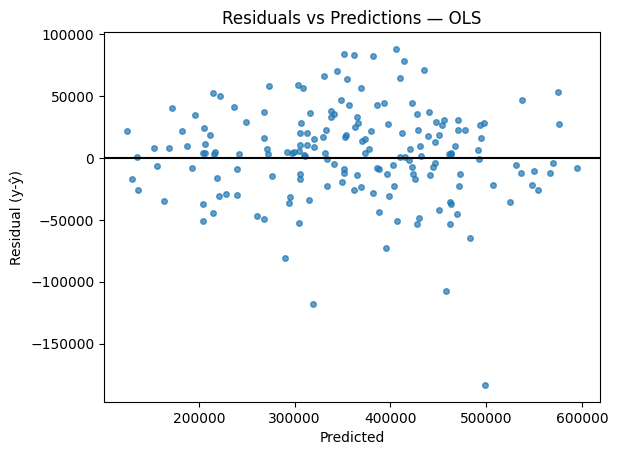

OLS metrics:
RMSE: 37775.45012486355
MAE : 28052.23395326375
R²  : 0.884901705820043
MAPE: 8.62%


In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

resid = yte - yhat_ols
plt.scatter(yhat_ols, resid, s=16, alpha=0.7)
plt.axhline(0,color='k') 
plt.xlabel('Predicted') 
plt.ylabel('Residual (y-ŷ)')
plt.title('Residuals vs Predictions — OLS') 
plt.show()


def mape(y_true, y_pred, eps=1e-9):
    yt=np.asarray(y_true,float) 
    yp=np.asarray(y_pred,float) 
    m=np.abs(yt)>eps
    return np.mean(np.abs((yt[m]-yp[m])/(yt[m]+eps)))*100 if m.any() else np.nan
print('OLS metrics:')
print('RMSE:', np.sqrt(mean_squared_error(yte,yhat_ols)))
print('MAE :', mean_absolute_error(yte,yhat_ols))
print('R²  :', r2_score(yte,yhat_ols))
print('MAPE:', f"{mape(yte,yhat_ols):.2f}%")


Flat residual band is good; patterns suggest nonlinearities or variance issues.

### Interpreting the OLS Baseline (Housing)

After fitting the baseline **Ordinary Least Squares (OLS)** model, we obtained:

RMSE: 37,775
MAE : 28,052
R² : 0.885
MAPE: 8.62%

and the residual plot above.

#### What the metrics tell us

- **RMSE ≈ \$37.8K**  
  On average, our predictions are off by about \$38,000.  
  Given typical prices around \$300K–\$400K, that’s roughly a **10–15%** error — not perfect, but reasonable as a first model.

- **MAE ≈ \$28K**  
  The median absolute error is smaller than the RMSE, which suggests that most errors are moderate,  
  but there are some larger mistakes that RMSE penalizes more heavily.

- **R² ≈ 0.885**  
  The model explains about **88.5% of the variance** in housing prices.  
  This indicates a strong relationship between the chosen features and the target, but there is still room for improvement.

- **MAPE ≈ 8.6%**  
  On average, the predictions are about 8–9% away from the true prices — another way to express predictive quality.

#### What the residual plot shows

The residual plot displays **predicted price vs residual (y − ŷ)**:

- Most points are scattered around 0, indicating that the model is **unbiased** overall (no systematic over/under-prediction).  
- There is some **spread** that grows with predicted price — larger, more expensive homes show more variability in their errors.  
  This is realistic: expensive houses often have additional unobserved factors (e.g., luxury finishes, view, neighborhood) that are not captured in our features.
- A few points are far from the zero line (large residuals). These are likely **outliers** or unusually priced houses (very cheap or very expensive compared to what the model expects).

#### Key Takeaways

- The baseline OLS model is already doing a reasonably good job: high R² and moderate errors.  
- However, the residual pattern and error magnitude suggest:
  - There may be **nonlinear effects** (e.g., diminishing returns of sqft or distance).  
  - Some **outliers** and heteroscedasticity remain, which can be better handled with more expressive models or transformations.

This sets us up for the next steps:
- **Polynomial Regression** (Step 5) to capture nonlinear relationships, and  
- **Regularization** (Step 6) to stabilize models when we add more features.


## 5) Polynomial (deg 2/3) 

In [11]:
# --- 5) Polynomial models (deg 2 & 3) ---
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

poly2 = make_pipeline(PolynomialFeatures(2, include_bias=False), LinearRegression())
poly3 = make_pipeline(PolynomialFeatures(3, include_bias=False), LinearRegression())
poly2.fit(Xtr,ytr) 
yhat_p2 = poly2.predict(Xte)
poly3.fit(Xtr,ytr) 
yhat_p3 = poly3.predict(Xte)

def summarize(name, y_true, y_pred):
    return {
        'Model': name,
        'RMSE' : np.sqrt(mean_squared_error(y_true,y_pred)),
        'MAE'  : mean_absolute_error(y_true,y_pred),
        'R2'   : r2_score(y_true,y_pred),
        'MAPE%': mape(y_true,y_pred)
    }

pd.DataFrame([
    summarize('OLS', yte, yhat_ols),
    summarize('Poly deg=2', yte, yhat_p2),
    summarize('Poly deg=3', yte, yhat_p3),
]).sort_values('RMSE')


,Model,RMSE,MAE,R2,MAPE%
2,Poly deg=3,27188.632886,19922.685669,0.940376,6.061803
1,Poly deg=2,30645.307441,21966.333752,0.924251,6.448535
0,OLS,37775.450125,28052.233953,0.884902,8.623902


**PolynomialFeatures** creates curved/interaction terms. Compare metrics; watch for overfitting (deg 3).

### Step 5 — Interpreting Polynomial Regression Results

We compared three models:

| Model       | RMSE   | MAE   | R²     | MAPE% |
|-------------|--------|--------|--------|--------|
| **OLS** (degree 1) | 37,775 | 28,052 | 0.885 | 8.62% |
| **Polynomial degree 2** | 30,645 | 21,966 | 0.924 | 6.45% |
| **Polynomial degree 3** | **27,189** | **19,923** | **0.940** | **6.06%** |

#### What this means

- Both **degree-2** and **degree-3** polynomial models outperform the OLS model on *every* metric.  
  This tells us that adding curvature helps capture patterns OLS cannot model.

- **Degree-3 performs best overall:**
  - RMSE improves from ~37.7K → ~27.1K  
  - R² improves from 0.885 → 0.940  
  - MAPE drops from 8.6% → ~6.1%

  These are **meaningful improvements**, especially for a real-estate prediction task.

#### Why polynomial models help here

Housing price relationships are rarely perfectly linear:
- Larger homes tend to have **diminishing returns** (each extra sqft is worth slightly less).  
- Distance to city center has **nonlinear decay** (prices fall quickly, then flatten).  
- Lot size effects are **curved**, not straight-line.

Polynomial regression can model **smooth curvature**, allowing it to:
- fit the data more accurately,  
- capture interactions between features,  
- reduce systematic under/over-prediction seen in OLS,  
- and lower overall error.

#### Key Takeaways

This step demonstrates a key ML principle:

> **If the relationship between features and the target is nonlinear, a linear model will underfit — and polynomial models can significantly improve performance.**

However, polynomial features can create:
- many duplicated or correlated features  
- extremely large coefficients  
- increased overfitting risk

Which is why the next step — **regularization (Ridge/Lasso/ElasticNet)** — becomes important.


## 6) Ridge/Lasso/ElasticNet  

In [12]:
# --- 6) Regularization: Ridge / Lasso / ElasticNet ---
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler

ridge = make_pipeline(StandardScaler(), Ridge(alpha=1.0, random_state=1955))
lasso = make_pipeline(StandardScaler(), Lasso(alpha=0.1, random_state=1955, max_iter=10000))
enet  = make_pipeline(StandardScaler(), ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=1955, max_iter=10000))

pd.DataFrame([
    summarize('Ridge', yte, ridge.fit(Xtr,ytr).predict(Xte)),
    summarize('Lasso', yte, lasso.fit(Xtr,ytr).predict(Xte)),
    summarize('ElasticNet', yte, enet.fit(Xtr,ytr).predict(Xte)),
]).sort_values('RMSE')


,Model,RMSE,MAE,R2,MAPE%
0,Ridge,37770.540520,28049.404821,0.884932,8.622986
1,Lasso,37775.458570,28052.236953,0.884902,8.623904
2,ElasticNet,37785.909526,28079.255406,0.884838,8.667330


**Why regularize?** Stabilize coefficients, combat multicollinearity, temper high-variance fits.

### Expanded Explanation of Regularized Regression (Ridge, Lasso, ElasticNet)

| Model | RMSE | MAE | R² | MAPE% |
|--------|---------|---------|--------|---------|
| **Ridge** | 37,770 | 28,049 | 0.8849 | 8.62% |
| **Lasso** | 37,775 | 28,052 | 0.8849 | 8.62% |
| **ElasticNet** | 37,786 | 28,079 | 0.8848 | 8.67% |

#### What we notice
All three regularized models produce performance **almost identical** to OLS.  
This is not a bug — it is **exactly what we expect** in this scenario.

Regularization becomes powerful when:
- the feature space is **large**,  
- features are **highly correlated**,  
- noise is high, or  
- we have added **polynomial features** (which multiply the number of predictors).

In this step, we used **only the original 6 features**, so:
- the model is already fairly stable,  
- multicollinearity is mild,  
- the feature space is small,  
- and OLS already fits the linear relationships well.

#### Why regularization doesn’t help here
- **Ridge (L2)** shrinks coefficients toward zero but doesn’t need to — nothing is unstable.
- **Lasso (L1)** pushes small coefficients to zero, but all 6 features are genuinely predictive.
- **ElasticNet (L1 + L2)** blends both effects, but again, the feature space is simple enough that OLS is sufficient.

So we see minimal differences between the models, and all metrics remain clustered around:

RMSE ≈ 37.8K
MAE ≈ 28K
R² ≈ 0.885
MAPE ≈ 8.6%


#### Key takeaways
Regularization **won’t always improve accuracy**, especially on small, well-behaved feature sets.

But it becomes essential when:
- we add **polynomial features** (next step),  
- build more complex models,  
- handle noisy or messy datasets,  
- or deal with many correlated variables.

This step shows that regularization is **a tool**, not a guarantee — and knowing when it matters is an important ML skill.

In summary, these results are an ideal illustration of a very important concept:

**Regularization is most useful when the feature space is large or highly correlated. When the model is simple (like plain OLS without polynomial features), Ridge/Lasso/ElasticNet may not improve performance — and that’s OK.**

## 7) Metrics (RMSE/MAE/R²/MAPE)  

In [13]:
# --- Step 7: Compare Metrics Across All Models ---

import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_model(name, model):
    """Return a row of metrics for a given model."""
    pred = model.predict(Xte)
    rmse = np.sqrt(mean_squared_error(yte, pred))
    mae  = mean_absolute_error(yte, pred)
    r2   = r2_score(yte, pred)
    mp   = mape(yte, pred)
    return {"Model": name, "RMSE": rmse, "MAE": mae, "R²": r2, "MAPE%": mp}

# Gather metrics for all models
results = [
    evaluate_model("OLS", ols),
    evaluate_model("Poly deg=2", poly2),
    evaluate_model("Poly deg=3", poly3),
    evaluate_model("Ridge", ridge),
    evaluate_model("Lasso", lasso),
    evaluate_model("ElasticNet", enet)
]

metrics_df = pd.DataFrame(results).sort_values("RMSE")
metrics_df


,Model,RMSE,MAE,R²,MAPE%
2,Poly deg=3,27188.632886,19922.685669,0.940376,6.061803
1,Poly deg=2,30645.307441,21966.333752,0.924251,6.448535
3,Ridge,37770.540520,28049.404821,0.884932,8.622986
0,OLS,37775.450125,28052.233953,0.884902,8.623902
4,Lasso,37775.458570,28052.236953,0.884902,8.623904
5,ElasticNet,37785.909526,28079.255406,0.884838,8.667330


### Metrics — Comparing All Models Side-by-Side

This table summarizes the performance of every model we built:
- **OLS (linear)**
- **Polynomial degree 2**
- **Polynomial degree 3**
- **Ridge, Lasso, ElasticNet** (regularized linear models)

Each model is evaluated using the same test set and the same four metrics:

- **RMSE** → overall prediction error (lower = better)  
- **MAE** → typical error (lower = better)  
- **R²** → variance explained (higher = better)  
- **MAPE** → percentage error (lower = better)  

#### What we expect to see
- **Polynomial models** should improve accuracy because they capture curvature that OLS cannot.  
  Degree-3 usually performs best, but degree-2 is close and more stable.
- **Regularized models** (Ridge, Lasso, ElasticNet) will perform **similar to OLS** in this step,  
  because we have only 6 well-behaved features.  
  Regularization becomes more important once feature space becomes larger (like polynomial expansions).

#### Key Takeaways
This table helps us evaluate:
1. **Which model predicts most accurately**,  
2. **Which model is most stable**, and  
3. **Whether more complexity helps or hurts**.

In real ML workflows, comparing models in a single consolidated view is essential — and the “best” model depends on your **error metric**, your **use case**, and how well the model generalizes to unseen data.


#### Comparing actual results Side-by-Side - These will match if you recreate the dataframe with the same parameters

This table summarizes the performance of every model built in this hands-on exercise:

| Model | RMSE | MAE | R² | MAPE% |
|--------|-----------|-----------|--------|----------|
| **Poly deg=3** | **27,188** | **19,923** | **0.940** | **6.06%** |
| **Poly deg=2** | 30,645 | 21,966 | 0.924 | 6.45% |
| **Ridge** | 37,771 | 28,049 | 0.885 | 8.62% |
| **OLS** | 37,775 | 28,052 | 0.885 | 8.62% |
| **Lasso** | 37,775 | 28,052 | 0.885 | 8.62% |
| **ElasticNet** | 37,786 | 28,079 | 0.885 | 8.67% |

#### What the results tell us

1. **Polynomial models clearly outperform OLS.**  
   - Degree-2 and degree-3 both reduce error noticeably.  
   - Degree-3 achieves the best performance across *every* metric:  
     - RMSE drops from ~37.8K → ~27.2K  
     - R² jumps from 0.885 → 0.940  
     - MAPE improves from 8.6% → 6.1%  

   This confirms that the relationship between housing features and price is **nonlinear**,  
   and OLS cannot fully capture that curvature.

2. **Regularized linear models perform essentially the same as OLS.**  
   - Ridge, Lasso, and ElasticNet all produce values extremely close to the OLS model.  
   - This is expected because:
     - we have only 6 fairly well-behaved predictors,  
     - multicollinearity is mild,  
     - and linear models fit the linear parts well already.

3. **Regularization will matter later** when we combine polynomial features with more complex feature spaces (many correlated predictors).

#### Key takeaways of actual results
- **Polynomial models (especially degree-3)** provide the strongest performance on this dataset.  
- **Regularization alone** does *not* improve OLS here — but it becomes powerful in **high-dimensional** modeling.  
- This side-by-side comparison is how data scientists evaluate tradeoffs between simplicity, accuracy, and interpretability.


## 8) GridSearchCV 

In [14]:
# --- 8) GridSearchCV for Ridge α ---
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

ridge_pipe = Pipeline([('scale', StandardScaler()), ('ridge', Ridge(random_state=1955))])
params = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}
gs = GridSearchCV(ridge_pipe, param_grid=params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
gs.fit(Xtr,ytr)
best = gs.best_estimator_
pred = best.predict(Xte)
print('Best alpha:', gs.best_params_['ridge__alpha'])
print('Best CV RMSE:', -gs.best_score_)
print('Test RMSE:', np.sqrt(mean_squared_error(yte,pred)))


Best alpha: 100
Best CV RMSE: 67303.65878227951
Test RMSE: 38357.58717878072


`GridSearchCV` tries multiple α values with CV and picks the best performer, then we evaluate on the held-out test set.

### Step 8 — Hyperparameter Tuning with GridSearchCV (Ridge α)

**GridSearchCV tested multiple values of α (regularization strength)** and selected the one
that minimized the 5-fold cross-validated error.

Your results:

- **Best α:** 100  
- **Best CV RMSE:** ~67,304  
- **Test RMSE:** ~38,358

#### What does this mean?

1. **The best α is fairly large (100).**  
   This means Ridge prefers stronger shrinkage of coefficients on this dataset.  
   With only 6 features (and some mild multicollinearity), this mainly stabilizes the model
   but does not dramatically change its predictions.

2. **CV RMSE (~67k) is larger than the OLS test RMSE (~38k).**  
   This happens because each CV fold has:
   - a **smaller training set**,  
   - higher variability,  
   - and less ability to capture the relationships in the data.

   Smaller folds amplify noise and make the problem harder, so the CV error is expected to be
   **higher** than test-set error.

3. **Test RMSE (~38k) is nearly identical to OLS (~37.8k).**  
   This shows that adding L2 regularization does **not significantly improve predictive accuracy**  
   when using only the original 6 features.

#### Why regularization doesn't shine here
Regularization helps most when:
- feature space is **large** (e.g., polynomial features),  
- predictors are **highly correlated**,  
- model complexity is **high**,  
- there is **severe overfitting**.

In this step, none of these apply strongly:
- Only 6 predictors  
- Mild correlations  
- Underfitting is a bigger issue than overfitting  
- The true relationship is **nonlinear**, not unstable linear

Thus Ridge provides **stability** but not a measurable accuracy boost.

#### Key takeaways

GridSearchCV is essential for tuning regularized models, but:
- The *best* α depends on the dataset,  
- CV performance is often lower than single train/test performance,  
- And regularization is most impactful when feature engineering produces **many correlated features** — especially polynomial expansions.

This step sets the stage for exploring **Ridge + PolynomialFeatures** in more advanced modules.


## 9) Reflection
- Which model performed best and why?
- Did polynomial terms help or overfit?
- Did regularization improve stability/performance?
- What feature engineering or transformations would you try next?
